<class 'pandas.core.series.Series'>
Index: 172782 entries, 0 to 541908
Series name: InvoiceNo
Non-Null Count   Dtype 
--------------   ----- 
172782 non-null  object
dtypes: object(1)
memory usage: 2.6+ MB
Raw transactions after cleaning: 168631
Unique customers: 2997
            Quantity      UnitPrice         Amount
count  168631.000000  168631.000000  168631.000000
mean       13.079546       3.147421      22.982061
std       201.856371      26.125811     427.780198
min         1.000000       0.040000       0.100000
25%         2.000000       1.250000       4.680000
50%         6.000000       1.950000      11.700000
75%        12.000000       3.750000      19.800000
max     80995.000000    8142.750000  168469.600000


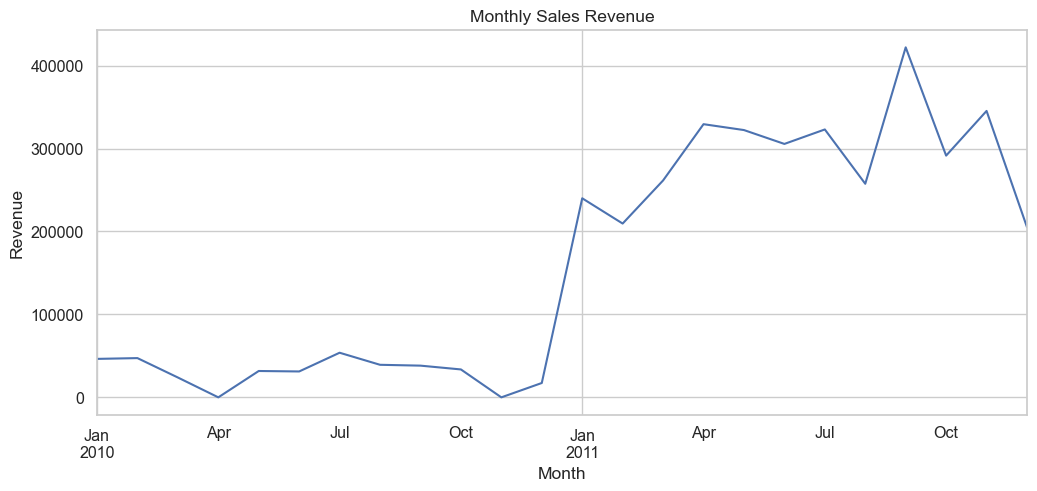

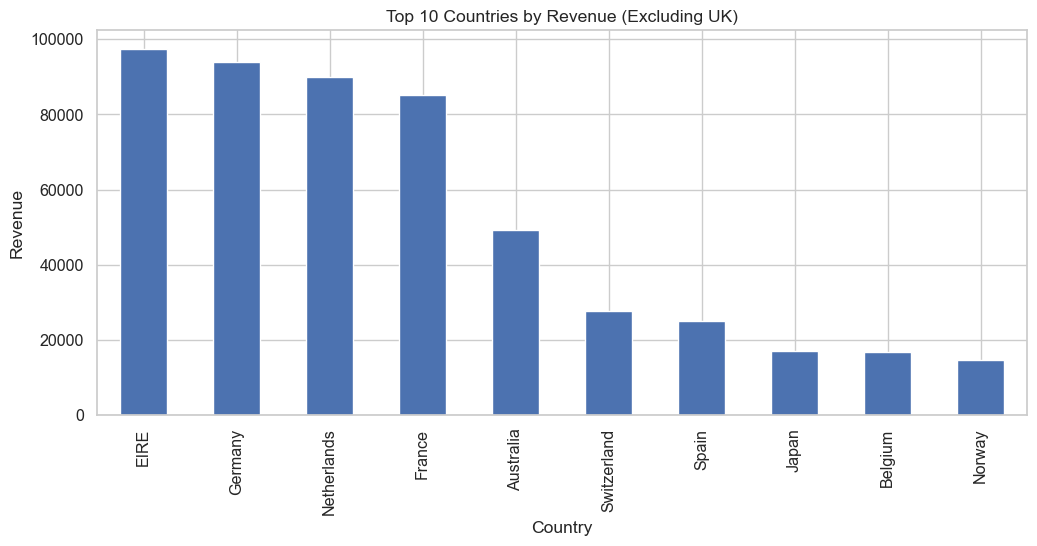

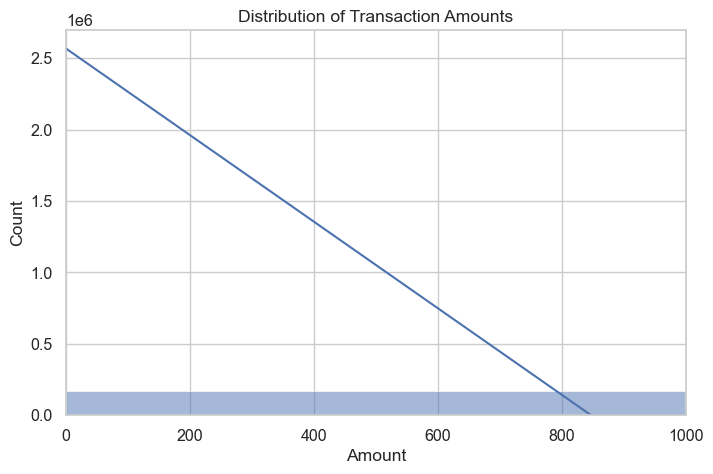

2011-12-11 17:19:00


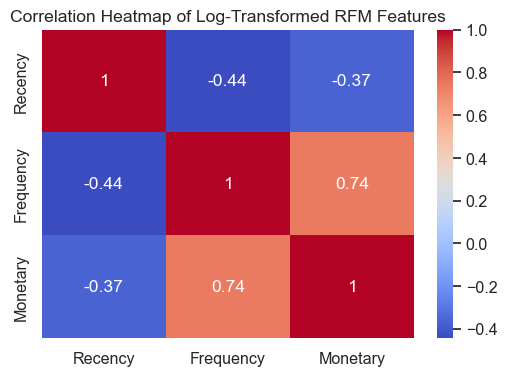

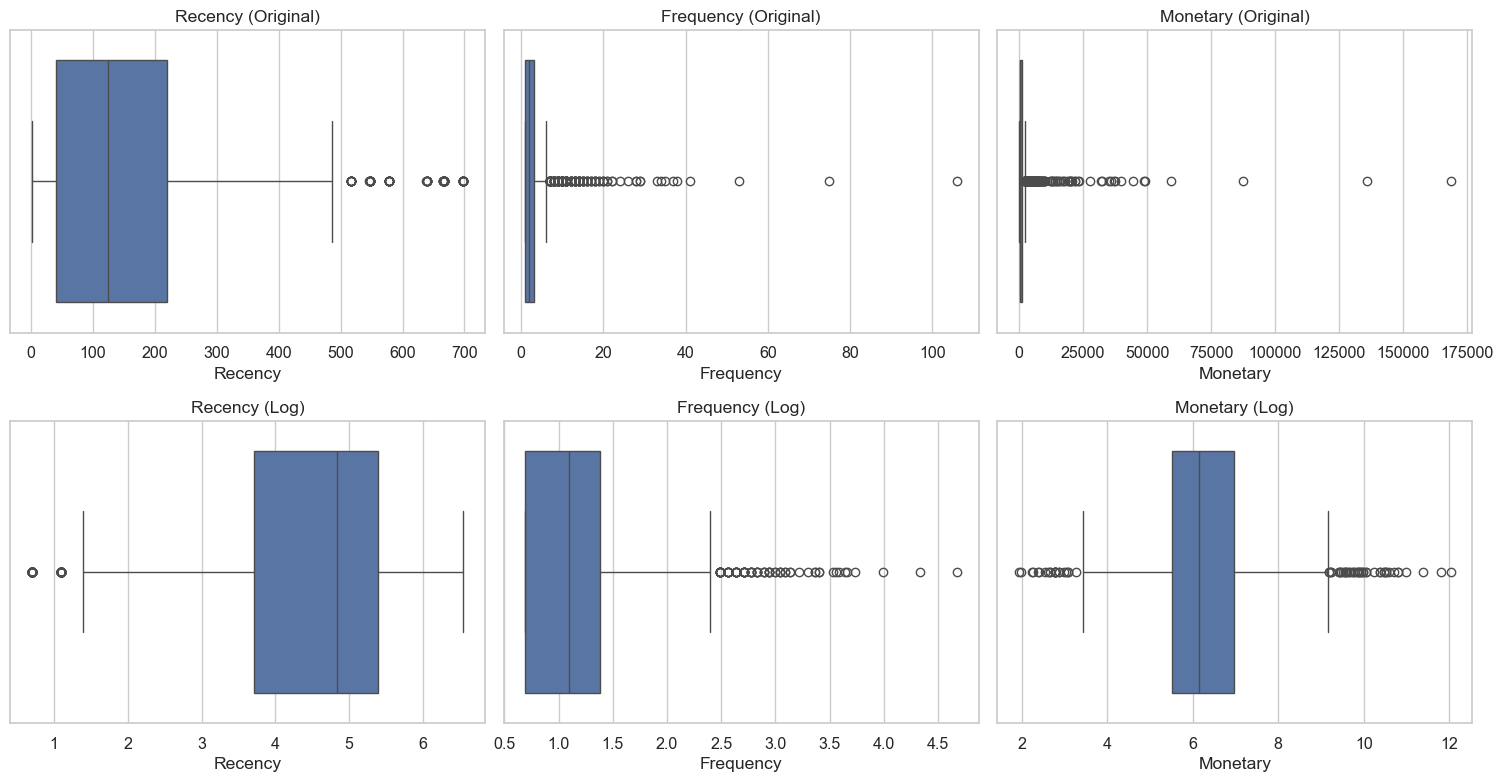

In [32]:
%run eda.ipynb

In [33]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

KMeans-Clustering

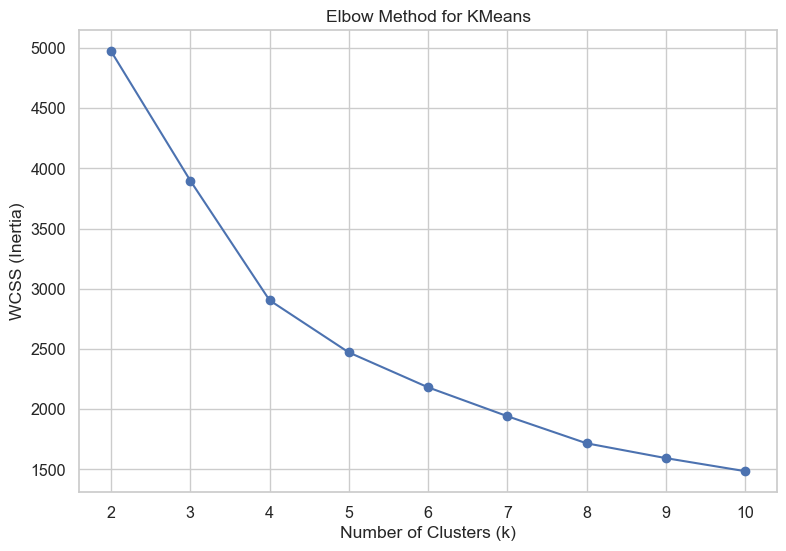

In [34]:
# Elbow Method
inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(rfm_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.show()

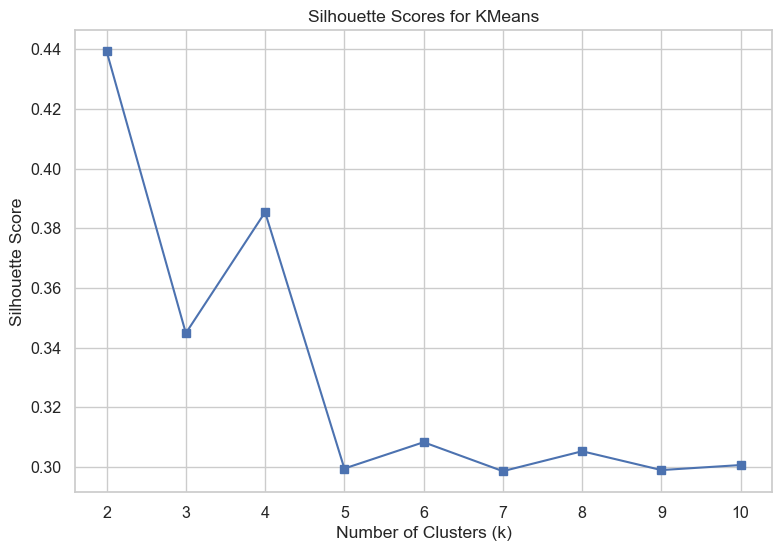

In [35]:
# Silhouette Method
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

plt.plot(K_range, sil_scores, marker='s')
plt.title("Silhouette Scores for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [36]:
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

optimal_k = K_range[np.argmax(sil_scores)]
print(f" Best K for KMeans: {optimal_k}, Silhouette Score: {max(sil_scores):.4f}")

 Best K for KMeans: 2, Silhouette Score: 0.4393


In [37]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
rfm["KMeans_Cluster"] = kmeans.fit_predict(rfm_scaled)

Hierarchical Clustering

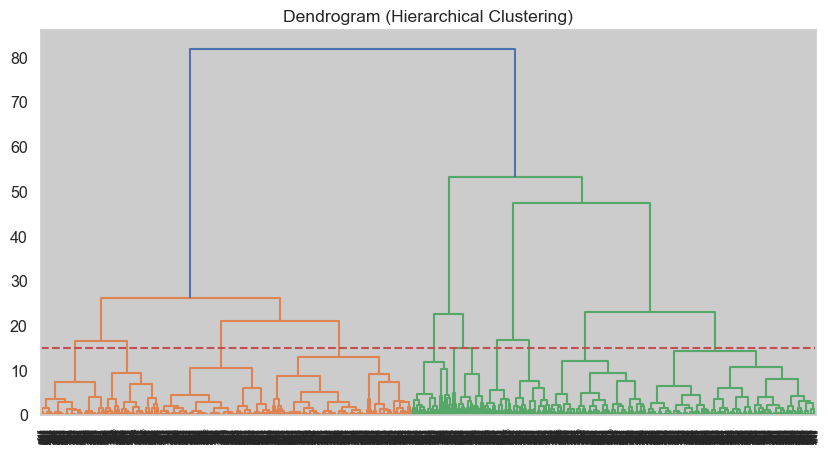

In [38]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10,5))
dend = sch.dendrogram(sch.linkage(rfm_scaled, method="ward"))
plt.axhline(y=15, color='r', linestyle='--') 
plt.title("Dendrogram (Hierarchical Clustering)")
plt.show()

In [39]:
# Silhouette Comparison
best_score, best_params = -1, None
for linkage in ["ward", "average", "complete"]:
    for k in range(3, 8):
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(rfm_scaled)
        score = silhouette_score(rfm_scaled, labels)
        if score > best_score:
            best_score, best_params = score, (linkage, k)




In [40]:
print(f"Best Hierarchical: linkage={best_params[0]}, k={best_params[1]} (Silhouette={best_score:.3f})")

Best Hierarchical: linkage=average, k=3 (Silhouette=0.502)


In [41]:
agglo = AgglomerativeClustering(n_clusters=best_params[1], linkage=best_params[0])
rfm["Hier_Cluster"] = agglo.fit_predict(rfm_scaled)

DBSCAN Parameter Tuning

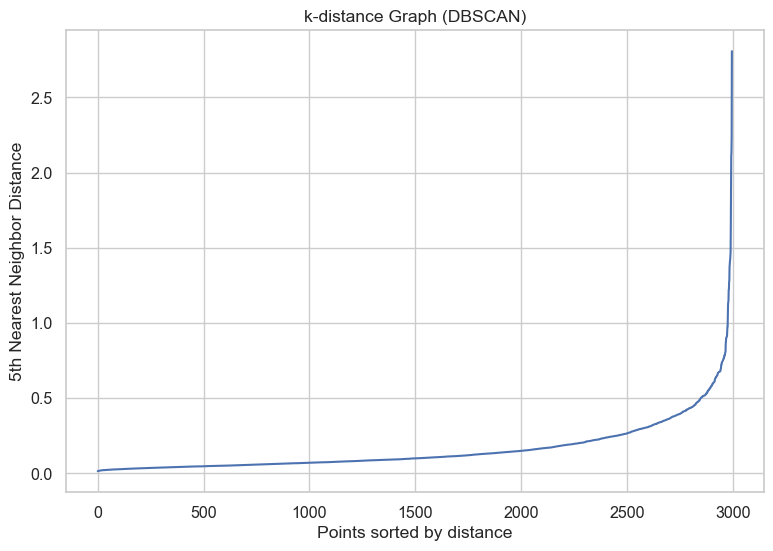

In [42]:
# k-distance graph
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 5])

plt.plot(distances)
plt.title("k-distance Graph (DBSCAN)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()

In [43]:
best_db_score, best_db_params = -1, None
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_s in [3,4,5, 6, 7, 8, 10]:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(rfm_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(rfm_scaled, labels)
            if score > best_db_score:
                best_db_score, best_db_params = score, (eps, min_s)

print(f" Best DBSCAN: eps={best_db_params[0]}, min_samples={best_db_params[1]} (Silhouette={best_db_score:.3f})")


 Best DBSCAN: eps=0.5, min_samples=5 (Silhouette=0.227)


In [44]:
dbscan = DBSCAN(eps=best_db_params[0], min_samples=best_db_params[1])
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

Cluster Comparison

In [45]:
print("\n Final Cluster Results:")
print("KMeans:", silhouette_score(rfm_scaled, rfm["KMeans_Cluster"]))
print("Hierarchical:", silhouette_score(rfm_scaled, rfm["Hier_Cluster"]))
print("DBSCAN:", silhouette_score(rfm_scaled, rfm["DBSCAN_Cluster"]))


 Final Cluster Results:
KMeans: 0.4393153981372435
Hierarchical: 0.5023594555842025
DBSCAN: 0.22687038610368254


Cluster 0  → Loyal & High-Value Customers.

Cluster 1  → Churned or Low-Value Customers.

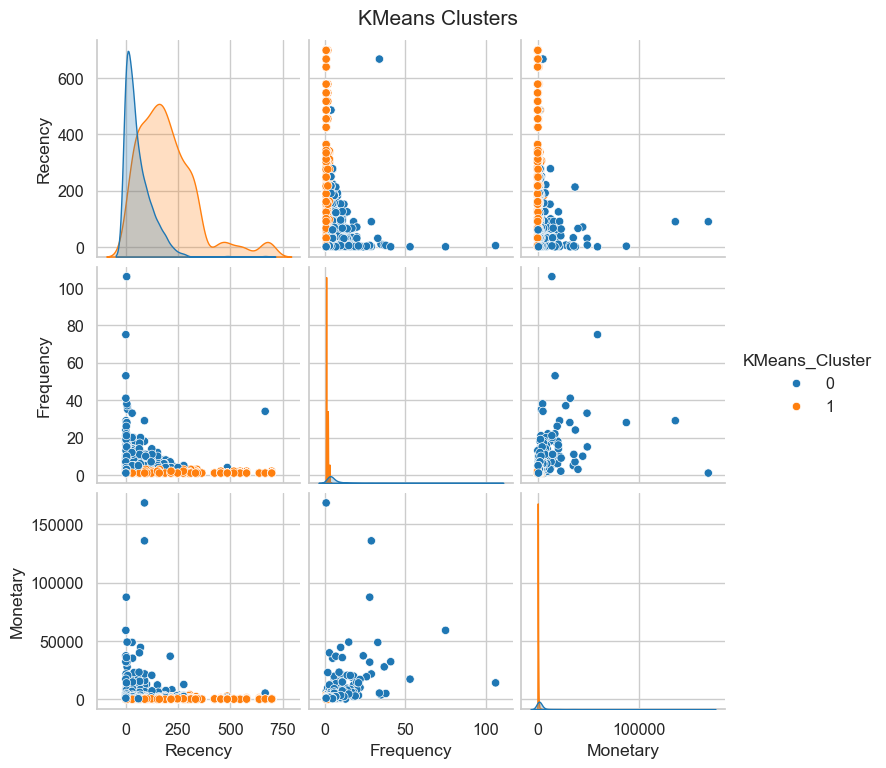

In [46]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="KMeans_Cluster", palette="tab10")
plt.suptitle("KMeans Clusters", y=1.02)
plt.show()

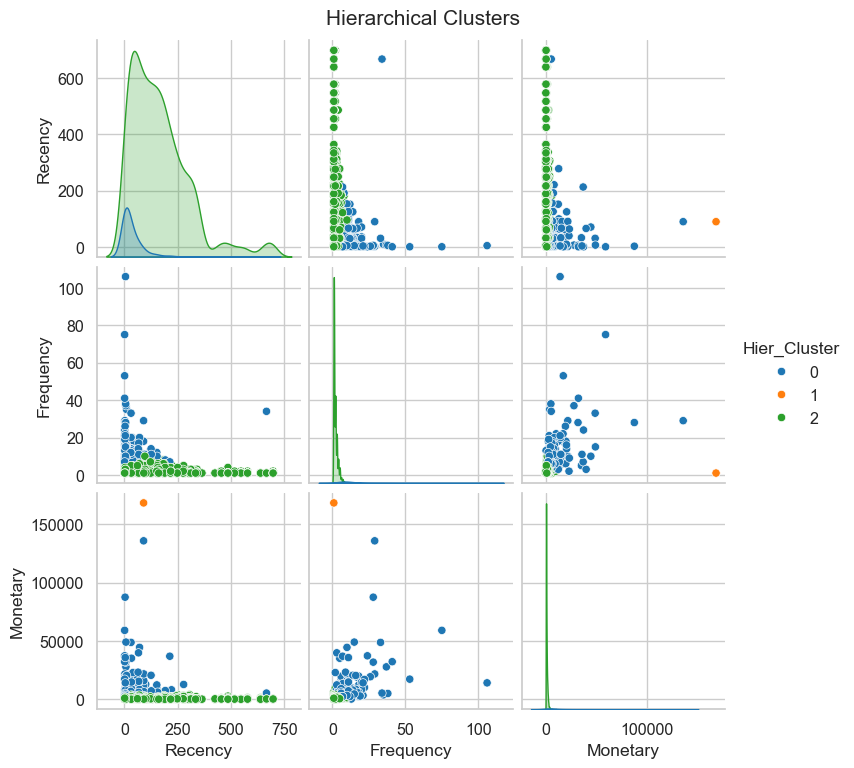

In [47]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="Hier_Cluster", palette="tab10")
plt.suptitle("Hierarchical Clusters", y=1.02)
plt.show()

Cluster 2 (Recency=4, Freq=2, Monetary=680) → Recent low spenders.

Cluster 3 (Recency=4, Freq=5.7, Monetary=2071) → Recent, frequent, high spenders (VIP).

Cluster 4 (Recency=152, Freq=2, Monetary=707) → Older moderate spenders.

Cluster 5 (Recency=4, Freq=1, Monetary=359) → Recent one-time buyers.

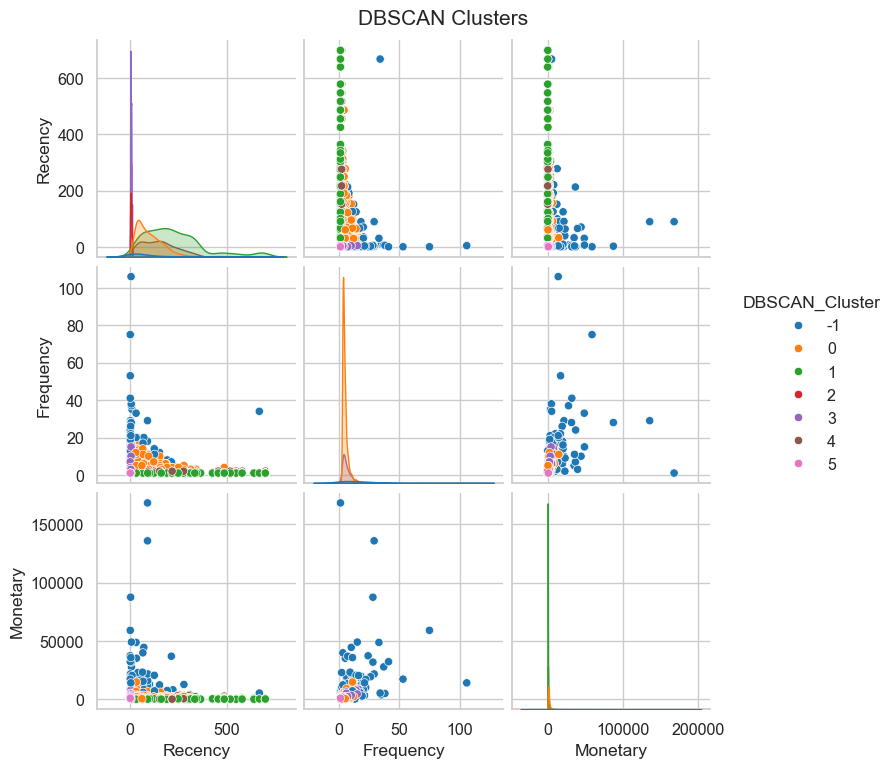

In [48]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="DBSCAN_Cluster", palette="tab10")
plt.suptitle("DBSCAN Clusters", y=1.02)
plt.show()

In [49]:
from sklearn.metrics import adjusted_rand_score

In [50]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


sil_kmeans = silhouette_score(rfm_scaled, rfm["KMeans_Cluster"])
sil_hier = silhouette_score(rfm_scaled, rfm["Hier_Cluster"])
sil_db = silhouette_score(rfm_scaled, rfm["DBSCAN_Cluster"]) if len(set(rfm["DBSCAN_Cluster"])) > 1 else -1

ch_kmeans = calinski_harabasz_score(rfm_scaled, rfm["KMeans_Cluster"])
ch_hier = calinski_harabasz_score(rfm_scaled, rfm["Hier_Cluster"])
ch_db = calinski_harabasz_score(rfm_scaled, rfm["DBSCAN_Cluster"]) if len(set(rfm["DBSCAN_Cluster"])) > 1 else -1

db_kmeans = davies_bouldin_score(rfm_scaled, rfm["KMeans_Cluster"])
db_hier = davies_bouldin_score(rfm_scaled, rfm["Hier_Cluster"])
db_db = davies_bouldin_score(rfm_scaled, rfm["DBSCAN_Cluster"]) if len(set(rfm["DBSCAN_Cluster"])) > 1 else -1


metrics_df = pd.DataFrame({
    "Model": ["KMeans", "Hierarchical", "DBSCAN"],
    "Silhouette Score ↑": [sil_kmeans, sil_hier, sil_db],
    "Calinski-Harabasz ↑": [ch_kmeans, ch_hier, ch_db],
    "Davies-Bouldin ↓": [db_kmeans, db_hier, db_db]
})

print("\nClustering Evaluation Metrics")
metrics_df




Clustering Evaluation Metrics


,Model,Silhouette Score ↑,Calinski-Harabasz ↑,Davies-Bouldin ↓
0,KMeans,0.439315,2417.851924,0.971942
1,Hierarchical,0.502359,586.403492,0.614819
2,DBSCAN,0.226870,948.337929,1.614359


In [51]:
ari_kmeans_hier = adjusted_rand_score(rfm["KMeans_Cluster"], rfm["Hier_Cluster"])
ari_kmeans_db = adjusted_rand_score(rfm["KMeans_Cluster"], rfm["DBSCAN_Cluster"])
ari_hier_db = adjusted_rand_score(rfm["Hier_Cluster"], rfm["DBSCAN_Cluster"])

print("\nAdjusted Rand Index (ARI):")
print(f"KMeans vs Hierarchical: {ari_kmeans_hier:.3f}")
print(f"KMeans vs DBSCAN: {ari_kmeans_db:.3f}")
print(f"Hierarchical vs DBSCAN: {ari_hier_db:.3f}")


Adjusted Rand Index (ARI):
KMeans vs Hierarchical: 0.174
KMeans vs DBSCAN: 0.397
Hierarchical vs DBSCAN: 0.084


In [52]:
def summarize_clusters(df, cluster_col):
    return df.groupby(cluster_col)[["Recency", "Frequency", "Monetary"]].mean().round(2)

print("\n🔹 KMeans Cluster Summary:")
print(summarize_clusters(rfm, "KMeans_Cluster"))

print("\n🔹 Hierarchical Cluster Summary:")
print(summarize_clusters(rfm, "Hier_Cluster"))

print("\n🔹 DBSCAN Cluster Summary (excluding noise):")
if -1 in rfm["DBSCAN_Cluster"].unique():
    print(summarize_clusters(rfm[rfm["DBSCAN_Cluster"] != -1], "DBSCAN_Cluster"))
else:
    print(summarize_clusters(rfm, "DBSCAN_Cluster"))


🔹 KMeans Cluster Summary:
                Recency  Frequency  Monetary
KMeans_Cluster                              
0                 58.10       5.51   3228.52
1                199.16       1.37    422.33

🔹 Hierarchical Cluster Summary:
              Recency  Frequency   Monetary
Hier_Cluster                               
0               35.16      12.00    9001.63
1               90.00       1.00  168469.60
2              164.01       1.99     681.94

🔹 DBSCAN Cluster Summary (excluding noise):
                Recency  Frequency  Monetary
DBSCAN_Cluster                              
0                 99.58       4.51   1649.69
1                225.98       1.00    353.37
2                  4.42       2.00    679.86
3                  4.20       5.98   2266.31
4                152.93       2.00    705.97
5                  4.55       1.00    358.71


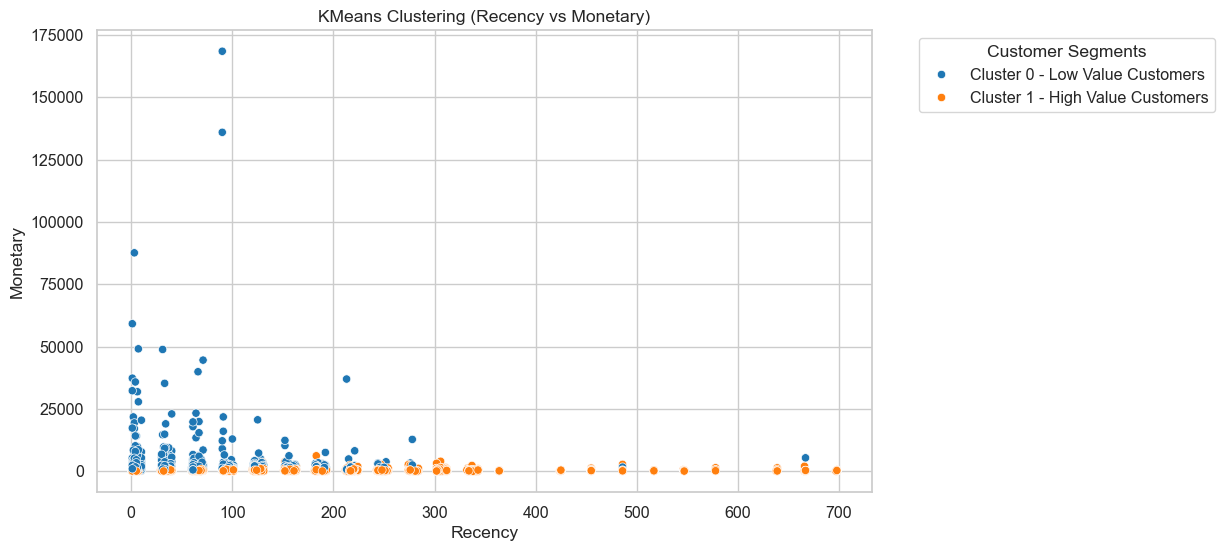

In [65]:

cluster_labels = {
    0: "Cluster 0 - Low Value Customers",
    1: "Cluster 1 - High Value Customers"
}

rfm["KMeans_Label"] = rfm["KMeans_Cluster"].map(cluster_labels)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="KMeans_Label",   
    palette="tab10"
)
plt.title("KMeans Clustering (Recency vs Monetary)")
plt.legend(title="Customer Segments", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


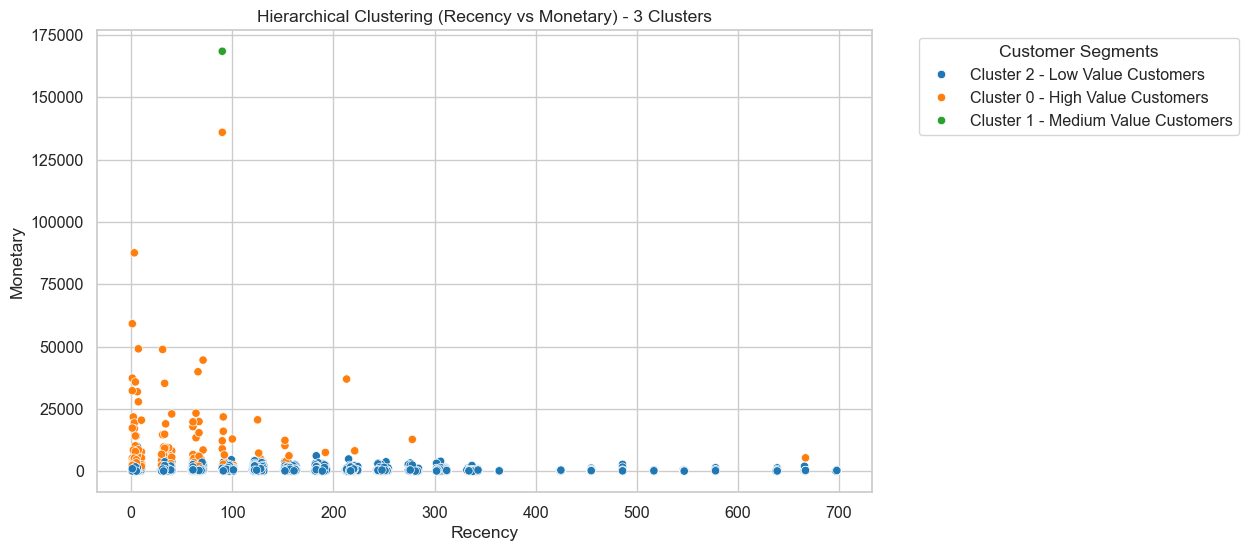

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map cluster IDs to meaningful names (you can edit labels based on analysis)
cluster_labels = {
    0: "Cluster 0 - High Value Customers",
    1: "Cluster 1 - Medium Value Customers",
    2: "Cluster 2 - Low Value Customers"
}

# Add a new column with descriptive labels
rfm["Hier_Label"] = rfm["Hier_Cluster"].map(cluster_labels)

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Hier_Label", 
    palette="tab10"
)
plt.title("Hierarchical Clustering (Recency vs Monetary) - 3 Clusters")
plt.legend(title="Customer Segments", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

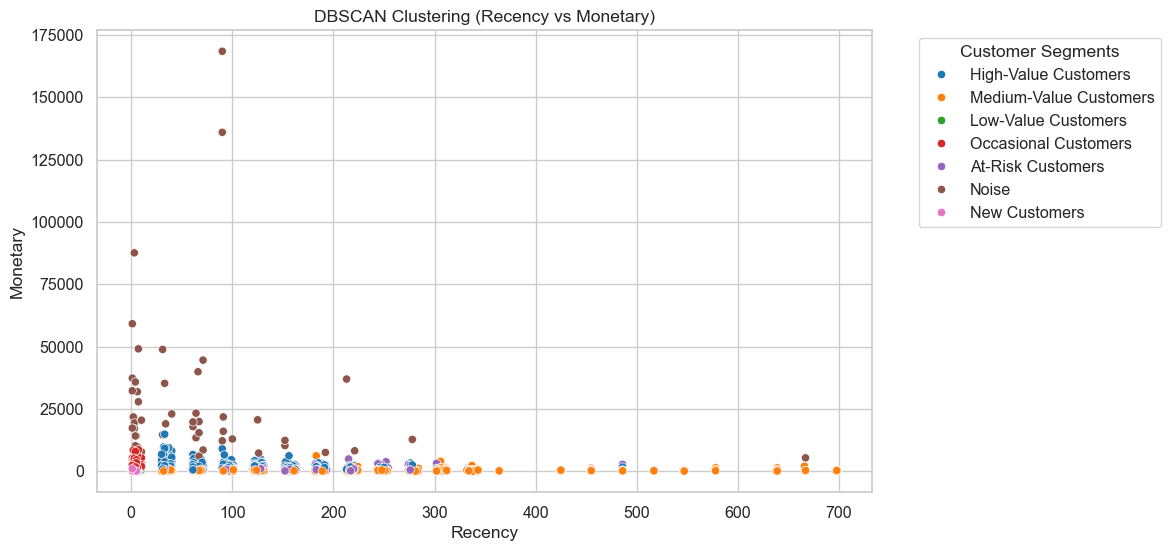

In [ ]:
cluster_labels = {
    -1: "Noise",
     0: "High-Value Customers",
     1: "Medium-Value Customers",
     2: "Low-Value Customers",
     3: "Occasional Customers",
     4: "At-Risk Customers",
     5: "New Customers"
}

rfm["DBSCAN_Label"] = rfm["DBSCAN_Cluster"].map(cluster_labels)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm, 
    x="Recency", 
    y="Monetary", 
    hue="DBSCAN_Label", 
    palette="tab10"
)
plt.title("DBSCAN Clustering (Recency vs Monetary)")
plt.legend(title="Customer Segments", bbox_to_anchor=(1.05, 1), loc='upper left')  # legend outside
plt.show()

In [56]:
import plotly.express as px

fig_kmeans = px.scatter_3d(rfm, 
                           x='Recency', y='Frequency', z='Monetary',
                           color='KMeans_Cluster',
                           title="KMeans Clusters (3D)",
                           opacity=0.7, size_max=10)
fig_kmeans.show()

In [57]:

fig_hier = px.scatter_3d(rfm, 
                         x='Recency', y='Frequency', z='Monetary',
                         color='Hier_Cluster',
                         title="Hierarchical Clusters (3D)",
                         opacity=0.7, size_max=10)
fig_hier.show()

In [63]:
import plotly.express as px

fig_dbscan = px.scatter_3d(
    rfm, 
    x='Recency', 
    y='Frequency', 
    z='Monetary',
    color='DBSCAN_Cluster',
    title="DBSCAN Clusters (3D)",
    opacity=0.7, 
    size_max=10,
    labels={"DBSCAN_Cluster": "Customer Segment"}  # Legend title
)


fig_dbscan.show()


In [60]:

def label_customer_quality(cluster):
    if cluster == -1:
        return "Noise/Outlier"
    elif cluster == 0:
        return "High-Value"
    elif cluster == 1:
        return "Medium-Value"
    elif cluster == 2:
        return "Low-Value"
    elif cluster == 3:
        return "Potential"
    elif cluster == 4:
        return "Churn Risk"
    elif cluster == 5:
        return "New Customers"
    else:
        return "Other"


rfm["Customer_Quality"] = rfm["DBSCAN_Cluster"].apply(label_customer_quality)


rfm.to_csv("rfm_with_customer_quality.csv", index=False)
print("Dataset with customer quality saved as rfm_with_customer_quality.csv")


Dataset with customer quality saved as rfm_with_customer_quality.csv


In [ ]:
def label_customer_quality(cluster):
    if cluster == 0:
        return "High-Value"
    elif cluster == 1:
        return "VIP / Big Spenders"
    elif cluster == 2:
        return "Low-Value"
    else:
        return "Other"

rfm["Customer_Quality_Hier"] = rfm["Hier_Cluster"].apply(label_customer_quality)

rfm.to_csv("rfm_with_hier_customer_quality.csv", index=False)
print("Dataset saved as rfm_with_hier_customer_quality.csv")


Dataset saved as rfm_with_hier_customer_quality.csv


In [59]:
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(dbscan, "dbscan_model.pkl")
joblib.dump(agglo, "agglo_model.pkl")

['agglo_model.pkl']